In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from collections import Counter, defaultdict
import joblib
import math

## 1 Distributional Counting

### 1.1 implement distributional counting

In [151]:
def distrib_counting(doc, w, V, Vc, wv):

    """ 
    inputs:
        - doc: list of words; a **single** document to do distributional counting on
        - w: integer; window size
        - V: set of words; vocabulary
        - Vc: set of words; context vocabulary
        - wv: dict of counters; mapping from each V to Vc to counts
    outputs: 
        none. the function mutates wv.
    """

    # sliding window
    for i, center in enumerate(doc):

        # count only if the center word is in vocab
        if center in V:

            # get the start and end idx of window
            start = max(0, i - w)
            end = min(i + w + 1, len(doc))   # upper bound exclusive

            # counting co-occurences
            for j in range(start, end):

                # skip center word
                if j == i:
                    continue

                # increment counts if doc[j] is in contex vocab
                if doc[j] in Vc:
                    wv[center][doc[j]] += 1

In [152]:
# sanity check with toy example
wv = defaultdict(Counter)
distrib_counting(
    doc=['rest', 'for', 'the', 'rest', 'of', 'the', 'day'],
    w=3, 
    V=set(['day', 'for', 'of', 'rest', 'the']),
    Vc=set(['day', 'for', 'of', 'rest', 'the']),
    wv=wv
)
wv

defaultdict(collections.Counter,
            {'rest': Counter({'for': 2,
                      'the': 3,
                      'rest': 2,
                      'of': 1,
                      'day': 1}),
             'for': Counter({'rest': 2, 'the': 1, 'of': 1}),
             'the': Counter({'rest': 3,
                      'for': 1,
                      'of': 2,
                      'the': 2,
                      'day': 1}),
             'of': Counter({'for': 1, 'the': 2, 'rest': 1, 'day': 1}),
             'day': Counter({'rest': 1, 'of': 1, 'the': 1})})

In [153]:
# sanity check with toy example
wv = defaultdict(Counter)
distrib_counting(
    doc=['rest', 'for', 'the', 'rest', 'of', 'the', 'day'],
    w=3, 
    V=set(['day', 'for', 'of', 'rest', 'the']),
    Vc=set(['day', 'for', 'rest']),
    wv=wv
)
wv

defaultdict(collections.Counter,
            {'rest': Counter({'for': 2, 'rest': 2, 'day': 1}),
             'for': Counter({'rest': 2}),
             'the': Counter({'rest': 3, 'for': 1, 'day': 1}),
             'of': Counter({'for': 1, 'rest': 1, 'day': 1}),
             'day': Counter({'rest': 1})})

### 1.2 run distributional counting on data

In [154]:
def process_corpus(corpus_path, V, Vc, w):

    """ 
    apply distrib_counting() to each doc in corpus and return sparsely represented final word vecs.
    inputs:
        - corpus_path: string; path to txt corpus where each line is a space-seperated document
        - V: set of words; vocabulary
        - Vc: set of words; context vocabulary
        - w: integer; window size
    outputs: 
        - wv: sparsely represented final word vecs computed across all docs in the corpus
    """

    # initialize co-occurence counts storage: V - Vc - counts
    wv = defaultdict(Counter)

    # process corpus
    with open(corpus_path, 'r') as file:

        for i, line in enumerate(file):

            # # only process a subset of corpus for testing
            # if i >= 10:
            #     break

            # # print progress
            # if i % 100 == 0: print(f'document {i}')
        
            # split string into list of words
            doc = line.split()
            
            # count co-occurences in doc
            distrib_counting(
                doc=doc,
                w=w, 
                V=V,
                Vc=Vc,
                wv=wv
            )

    return wv

In [155]:
# load vocab-15kws.txt
vocab15kws_path = 'data/vocab-15kws.txt'
with open(vocab15kws_path, 'r') as file:
    vocab15kws = set(file.read().splitlines())
len(vocab15kws)

15228

In [156]:
# load vocab-5k.txt
vocab5k_path = 'data/vocab-5k.txt'
with open(vocab5k_path, 'r') as file:
    vocab5k = set(file.read().splitlines())
len(vocab5k)

5000

In [157]:
# set corpus path
corpus_path = 'data/wiki-1percent.txt'

#### w = 3

In [158]:
# w = 3
wv_V15k_Vc5k_win3 = process_corpus(
                        corpus_path=corpus_path,
                        V=vocab15kws,
                        Vc=vocab5k,
                        w=3
                    )

In [27]:
# save
joblib.dump(wv_V15k_Vc5k_win3, 'results/wv_V15k_Vc5k_win3.pkl')

['results/wv_V15k_Vc5k_win3.pkl']

In [159]:
# retrieve co-occurence counts
wv_V15k_Vc5k_win3['coffee']['coffee']

4

#### w = 6

In [35]:
# w = 6
wv_V15k_Vc5k_win6 = process_corpus(
                        corpus_path=corpus_path,
                        V=vocab15kws,
                        Vc=vocab5k,
                        w=6
                    )

In [36]:
# save
joblib.dump(wv_V15k_Vc5k_win6, 'results/wv_V15k_Vc5k_win6.pkl')

['results/wv_V15k_Vc5k_win6.pkl']

In [166]:
# retrieve co-occurence counts
wv_V15k_Vc5k_win6['coffee']['coffee']

36

### 1.3 evalWS on distributional counting

In [167]:
def cos_sim(a, b):

    ab_dot = a@b
    ab_norm = np.linalg.norm(a) * np.linalg.norm(b)

    if ab_norm:   # if both word vectors have length
        return ab_dot / ab_norm
    else:   # if either word has a 0-length word vector, define cos_sim as 0
        return 0


def cos_sim_sparse(w1, w2, Vc, wv_sparse):

    """ 
    inputs:
        - w1, w2: string; the two words to compute cosine similarity between
        - Vc: set of words; context vocabulary
        - wv_sparse: defaultdict; mapping V - Vc - counts
    outputs: 
        - cos_sim between w1 and w2 computed using model wv_sparse
    """

    ab_dot = 0
    for w_context in Vc:   # we retrieve context word counts for w1 and w2 in the same iter so no need to convert Vc from set to list
        ab_dot += wv_sparse[w1][w_context] * wv_sparse[w2][w_context]

    ab_norm = np.linalg.norm(list(wv_sparse[w1].values())) * np.linalg.norm(list(wv_sparse[w2].values()))  # 0 entries does not matter for 2-norm

    if ab_norm:   # if both word vectors have length
        return ab_dot / ab_norm
    else:   # if either word has a 0-length word vector, define cos_sim as 0
        return 0

In [168]:
# sanity check
cos_sim_sparse(w1='sun', w2='sunlight', Vc=vocab5k, wv_sparse=wv_V15k_Vc5k_win3)

0.895510424327929

In [169]:
def evalWS(word_pairs, wv, Vc, true_sims):

    """ 
    inputs:
        - word_pairs: list of 2-word tuples to compute cosine similarity between
        - wv: defaultdict; wv model to be evaluated, mapping V - Vc - counts
        - Vc: set of words; context vocabulary
        - true_sims: 1d array of ground-truth similarity of each word_pair
    outputs: 
        - spearmanr between true_sims and wv_sims
    """

    # get wv similarity for word_pairs
    wv_sims = []
    for w1, w2 in word_pairs:
        wv_sims.append(cos_sim_sparse(w1=w1, w2=w2, Vc=Vc, wv_sparse=wv))
    
    # compute spearmanr between true_sims and wv_sims
    return spearmanr(true_sims, wv_sims)

#### simlex-999

In [170]:
# load simlex-999
simlex999_path = 'data/simlex-999.txt'

simlex999_words, simlex999_sims = [], []
with open(simlex999_path, 'r') as file:
    for line in file.read().splitlines()[1:]:
        w1, w2, sim = line.strip().split()
        simlex999_words.append((w1, w2))
        simlex999_sims.append(float(sim))
simlex999_sims = np.array(simlex999_sims)

print(f'simlex999_words len: {len(simlex999_words)}; simlex999_sims len: {len(simlex999_sims)}')

simlex999_words len: 999; simlex999_sims len: 999


In [200]:
eval_V15k_Vc5k_win3_counts_simlex = evalWS(word_pairs=simlex999_words, wv=wv_V15k_Vc5k_win3, Vc=vocab5k, true_sims=simlex999_sims)
eval_V15k_Vc5k_win3_counts_simlex

SpearmanrResult(correlation=0.05876135331349779, pvalue=0.06337563925440041)

#### MEN

In [172]:
# load MEN
MEN_path = 'data/men.txt'

MEN_words, MEN_sims = [], []
with open(MEN_path, 'r') as file:
    for line in file.read().splitlines()[1:]:
        w1, w2, sim = line.strip().split()
        MEN_words.append((w1, w2))
        MEN_sims.append(float(sim))
MEN_sims = np.array(MEN_sims)

print(f'MEN_words len: {len(MEN_words)}; MEN_sims len: {len(MEN_sims)}')

MEN_words len: 3000; MEN_sims len: 3000


In [201]:
eval_V15k_Vc5k_win3_counts_MEN = evalWS(word_pairs=MEN_words, wv=wv_V15k_Vc5k_win3, Vc=vocab5k, true_sims=MEN_sims)
eval_V15k_Vc5k_win3_counts_MEN

SpearmanrResult(correlation=0.2251396048448754, pvalue=8.800788745595221e-36)

## 2 Inverse Document Frequency (IDF)

### 2.1 implement TF-IDF

In [174]:
def IDF(corpus_path, Vc):

    # for storing number of doc/sentences containing each word in context vocab
    Vc_doc = defaultdict(int)

    # process corpus to count Vc occurence
    with open(corpus_path, 'r') as file:

        for i, line in enumerate(file):
        
            # split string into list of words, and convert to set to remove duplicates
            doc = set(line.split())
            
            # increment doc count for context vocab
            for word in doc:
                if word in Vc: Vc_doc[word] += 1

    # get total num of docs in corpus
    corpus_size = i + 1
    print(corpus_size)

    # compute IDF: corpus_size / freq
    return {word: (corpus_size / doc_count) for word, doc_count in Vc_doc.items()}

In [175]:
# compute IDF for Vc
Vc_IDF = IDF(corpus_path, vocab5k)

997898


In [176]:
def TF_IDF(wv_TF, Vc_IDF):

    """ 
    combine counts with IDF
    """

    # for storing counts combined with IDF 
    wv_TF_IDF = defaultdict(Counter)

    # iterate through every word pair in original count-based wv
    for w_center, w_context_count in wv_TF.items():
        for w_context, count in w_context_count.items():
            wv_TF_IDF[w_center][w_context] = count * Vc_IDF[w_context]

    return wv_TF_IDF

In [177]:
# compute TF_IDF for wv_V15k_Vc5k_win3
wv_V15k_Vc5k_win3_IDF = TF_IDF(wv_TF=wv_V15k_Vc5k_win3, Vc_IDF=Vc_IDF)

In [180]:
# save
joblib.dump(wv_V15k_Vc5k_win3_IDF, 'results/wv_V15k_Vc5k_win3_IDF.pkl')

['results/wv_V15k_Vc5k_win3_IDF.pkl']

### 2.2 evalWS on TF-IDF

In [198]:
# evaluate on simlex999
eval_V15k_Vc5k_win3_IDF_simlex = evalWS(word_pairs=simlex999_words, wv=wv_V15k_Vc5k_win3_IDF, Vc=vocab5k, true_sims=simlex999_sims)
eval_V15k_Vc5k_win3_IDF_simlex

SpearmanrResult(correlation=0.1643113945921928, pvalue=1.7660412054828056e-07)

In [199]:
# evaluate on MEN
eval_V15k_Vc5k_win3_IDF_MEN = evalWS(word_pairs=MEN_words, wv=wv_V15k_Vc5k_win3_IDF, Vc=vocab5k, true_sims=MEN_sims)
eval_V15k_Vc5k_win3_IDF_MEN

SpearmanrResult(correlation=0.47281906258988254, pvalue=5.778624720444274e-167)

## 3 Pointwise Mutual Information (PMI)

### 3.1 implement PMI

In [184]:
def PMI(wv_TF):
    
    """ 
    compute PMI from count-based wv
    """

    # for storing (non-normalized) px, py, N
    px = defaultdict(int)
    py = defaultdict(int)
    N = 0

    # count (non-normalized) px, py, N
    for w_center, w_context_count in wv_TF.items():
        for w_context, count in w_context_count.items():
            px[w_center] += count
            py[w_context] += count
            N += count


    # for storing PMI wv
    wv_PMI = defaultdict(Counter)

    # compute PMI
    for w_center, w_context_count in wv_TF.items():
        for w_context, count in w_context_count.items():
            wv_PMI[w_center][w_context] = math.log2(count * N / (px[w_center] * py[w_context]))

    return wv_PMI

In [185]:
# compute PMI from wv_V15k_Vc5k_win3
wv_V15k_Vc5k_win3_PMI = PMI(wv_TF=wv_V15k_Vc5k_win3)

In [186]:
# save
joblib.dump(wv_V15k_Vc5k_win3_PMI, 'results/wv_V15k_Vc5k_win3_PMI.pkl')

['results/wv_V15k_Vc5k_win3_PMI.pkl']

In [190]:
# sort PMI context words for coffee from high to low
coffee_low_high = sorted(wv_V15k_Vc5k_win3_PMI['coffee'].items(), 
                         key = lambda item: item[1],
                         reverse=True)

In [193]:
# print 10 highest
print('highest PMI: ')
for i in range(10):
    print(coffee_low_high[i])

# print 10 lowest
print('\n')
print('lowest PMI: ')
for i in range(1, 11):
    print(coffee_low_high[-i])

highest PMI: 
('tea', 8.16600126243293)
('drinking', 7.58797865873193)
('shop', 7.411693771493207)
('costa', 7.350256393786161)
('shops', 7.260751873418467)
('sugar', 6.533949521544205)
('coffee', 6.501977131805925)
('mix', 6.131195903101976)
('seattle', 5.950816325067398)
('houses', 5.868161497268183)


lowest PMI: 
('he', -2.26033826495274)
('be', -2.1509730526875237)
('had', -1.9875291676196303)
('this', -1.979549817934235)
('not', -1.9115928402014317)
('its', -1.839457915441101)
('after', -1.598505205571959)
('more', -1.4785257922880328)
('when', -1.4043486976803334)
('page', -1.2805627423998573)


### 3.2 evalWS on PMI-based word vectors

In [196]:
# evaluate on simlex999
eval_V15k_Vc5k_win3_PMI_simlex = evalWS(word_pairs=simlex999_words, wv=wv_V15k_Vc5k_win3_PMI, Vc=vocab5k, true_sims=simlex999_sims)
eval_V15k_Vc5k_win3_PMI_simlex

SpearmanrResult(correlation=0.18643183126956037, pvalue=2.8976468276084516e-09)

In [197]:
# evaluate on MEN
eval_V15k_Vc5k_win3_PMI_MEN = evalWS(word_pairs=MEN_words, wv=wv_V15k_Vc5k_win3_PMI, Vc=vocab5k, true_sims=MEN_sims)
eval_V15k_Vc5k_win3_PMI_MEN

SpearmanrResult(correlation=0.46563240836038006, pvalue=2.5050388889148127e-161)

## 4 Quantitative Comparisons

### 4.1 evalWS comparison  
(Vc=vocab15kws, Vc=vocab5k) x (w=1, w=3, w=6) x (counts, IDF, PMI) x (simlex999, MEN)

In [203]:
# w = 3, Vc = vocab5k
# shape: num methods (counts, IDF, PMI) x num test dataset (simlex999, MEN)

eval_V15k_Vc5k_win3_MxT = np.array([
    [eval_V15k_Vc5k_win3_counts_simlex[0], eval_V15k_Vc5k_win3_counts_MEN[0]],
    [eval_V15k_Vc5k_win3_IDF_simlex[0], eval_V15k_Vc5k_win3_IDF_MEN[0]],
    [eval_V15k_Vc5k_win3_PMI_simlex[0], eval_V15k_Vc5k_win3_PMI_MEN[0]]
])
eval_V15k_Vc5k_win3_MxT

array([[0.05876135, 0.2251396 ],
       [0.16431139, 0.47281906],
       [0.18643183, 0.46563241]])

In [204]:
def train_eval_3wv(corpus_path, V, Vc, w):

    # compute count-based wv
    wv_counts = process_corpus(
                            corpus_path=corpus_path,
                            V=V,
                            Vc=Vc,
                            w=w
                        )

    # eval wv_counts
    eval_counts_simlex = evalWS(word_pairs=simlex999_words, wv=wv_counts, Vc=Vc, true_sims=simlex999_sims)
    eval_counts_MEN = evalWS(word_pairs=MEN_words, wv=wv_counts, Vc=Vc, true_sims=MEN_sims)


    # compute IDF for Vc
    Vc_IDF = IDF(corpus_path=corpus_path, Vc=Vc)
    # compute TF-IDF wv
    wv_IDF = TF_IDF(wv_TF=wv_counts, Vc_IDF=Vc_IDF)

    # eval wv_IDF
    eval_IDF_simlex = evalWS(word_pairs=simlex999_words, wv=wv_IDF, Vc=Vc, true_sims=simlex999_sims)
    eval_IDF_MEN = evalWS(word_pairs=MEN_words, wv=wv_IDF, Vc=Vc, true_sims=MEN_sims)


    # compute PMI wv
    wv_PMI = PMI(wv_TF=wv_counts)

    # eval wv_PMI
    eval_PMI_simlex = evalWS(word_pairs=simlex999_words, wv=wv_PMI, Vc=Vc, true_sims=simlex999_sims)
    eval_PMI_MEN = evalWS(word_pairs=MEN_words, wv=wv_PMI, Vc=Vc, true_sims=MEN_sims)


    return np.array([
                [eval_counts_simlex[0], eval_counts_MEN[0]],
                [eval_IDF_simlex[0], eval_IDF_MEN[0]],
                [eval_PMI_simlex[0], eval_PMI_MEN[0]]
            ])

In [205]:
# w = 3, Vc = vocab15kws
# shape: num methods (counts, IDF, PMI) x num test dataset (simlex999, MEN)

eval_V15k_Vc15k_win3_MxT = train_eval_3wv(corpus_path=corpus_path, V=vocab15kws, Vc=vocab15kws, w=3)
eval_V15k_Vc15k_win3_MxT

997898


array([[0.0571423 , 0.22077842],
       [0.14785292, 0.48095232],
       [0.21229185, 0.5193931 ]])

In [206]:
# w = 6, Vc = vocab5k
# shape: num methods (counts, IDF, PMI) x num test dataset (simlex999, MEN)

eval_V15k_Vc5k_win6_MxT = train_eval_3wv(corpus_path=corpus_path, V=vocab15kws, Vc=vocab5k, w=6)
eval_V15k_Vc5k_win6_MxT

997898


array([[0.04469576, 0.24106665],
       [0.1106035 , 0.53239905],
       [0.15033132, 0.47240839]])

In [207]:
# w = 6, Vc = vocab15kws
# shape: num methods (counts, IDF, PMI) x num test dataset (simlex999, MEN)

eval_V15k_Vc15k_win6_MxT = train_eval_3wv(corpus_path=corpus_path, V=vocab15kws, Vc=vocab15kws, w=6)
eval_V15k_Vc15k_win6_MxT

997898


array([[0.04065367, 0.23691122],
       [0.10878207, 0.52510904],
       [0.16091152, 0.52741609]])

In [208]:
# w = 1, Vc = vocab5k
# shape: num methods (counts, IDF, PMI) x num test dataset (simlex999, MEN)

eval_V15k_Vc5k_win1_MxT = train_eval_3wv(corpus_path=corpus_path, V=vocab15kws, Vc=vocab5k, w=1)
eval_V15k_Vc5k_win1_MxT

997898


array([[0.0677857 , 0.20909154],
       [0.18922878, 0.34755926],
       [0.2274977 , 0.43360313]])

In [209]:
# w = 1, Vc = vocab15kws
# shape: num methods (counts, IDF, PMI) x num test dataset (simlex999, MEN)

eval_V15k_Vc15k_win1_MxT = train_eval_3wv(corpus_path=corpus_path, V=vocab15kws, Vc=vocab15kws, w=1)
eval_V15k_Vc15k_win1_MxT

997898


array([[0.07001369, 0.20639763],
       [0.18719989, 0.36616805],
       [0.26806515, 0.47023687]])

In [212]:
# putting all results together
# shape: (Vc5k, Vc15k) x (win1, win3, win6) x (counts, IDF, PMI) x (simlex, MEN)

eval_V15k = np.stack([
                np.stack([eval_V15k_Vc5k_win1_MxT, eval_V15k_Vc5k_win3_MxT, eval_V15k_Vc5k_win6_MxT]),
                np.stack([eval_V15k_Vc15k_win1_MxT, eval_V15k_Vc15k_win3_MxT, eval_V15k_Vc15k_win6_MxT])
            ])
eval_V15k.shape

(2, 3, 3, 2)

In [213]:
# save
joblib.dump(eval_V15k, 'results/eval_V15k.pkl')

['results/eval_V15k.pkl']

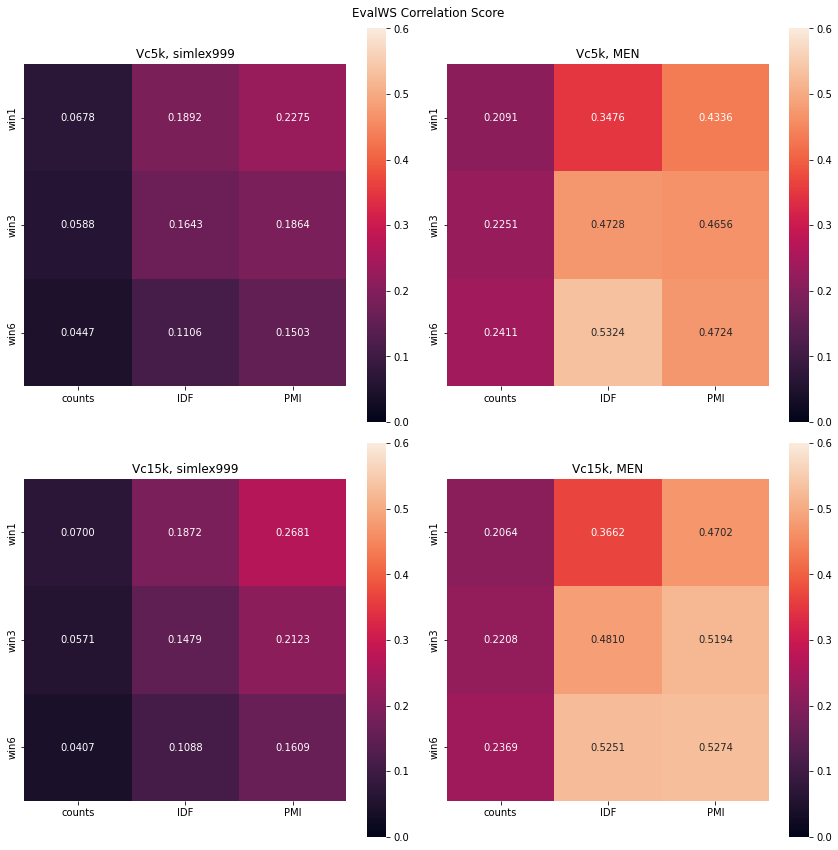

In [232]:
# methods x win

fig, ax = plt.subplots(figsize=(12, 12), nrows=2, ncols=2)


ax[0][0].set_title('Vc5k, simlex999')
sns.heatmap(eval_V15k[0,:,:,0], 
            fmt='.4f',
            vmin=0,
            vmax=0.6,
            annot=True, 
            square=True,
            xticklabels=['counts', 'IDF', 'PMI'],   # x axis is dim 2 in slice
            yticklabels=['win1', 'win3', 'win6'],   # y axis is dim 1 in slice
            ax=ax[0][0])


ax[0][1].set_title('Vc5k, MEN')
sns.heatmap(eval_V15k[0,:,:,1], 
            fmt='.4f',
            vmin=0,
            vmax=0.6,
            annot=True, 
            square=True,
            xticklabels=['counts', 'IDF', 'PMI'],
            yticklabels=['win1', 'win3', 'win6'],
            ax=ax[0][1])


ax[1][0].set_title('Vc15k, simlex999')
sns.heatmap(eval_V15k[1,:,:,0],
            fmt='.4f', 
            vmin=0,
            vmax=0.6,
            annot=True, 
            square=True,
            xticklabels=['counts', 'IDF', 'PMI'],
            yticklabels=['win1', 'win3', 'win6'],
            ax=ax[1][0])


ax[1][1].set_title('Vc15k, MEN')
sns.heatmap(eval_V15k[1,:,:,1],
            fmt='.4f', 
            vmin=0,
            vmax=0.6,
            annot=True, 
            square=True,
            xticklabels=['counts', 'IDF', 'PMI'],
            yticklabels=['win1', 'win3', 'win6'],
            ax=ax[1][1])


plt.suptitle('EvalWS Correlation Score')
plt.tight_layout()

### 4.2 notion of similarity in simlex999 vs MEN  
(see report)

## 5 Qualitative Analysis